In [1]:
using OMEinsum, SymEngine
using FastGaussQuadrature
using SparseIR
using LaTeXStrings
using Plots

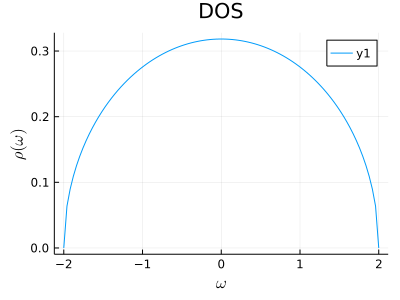

In [2]:
function rho_omega(omega::Vector{Float64})
    """
    compute spectral function rho(omega)
    """
    return sqrt.(4 .- omega.^2) ./ (2*pi)
end

num_omega = 100
omegas = collect(range(-2, 2, length=num_omega))
rho = rho_omega(omegas)
p = plot(xlabel="\$\\omega\$", ylabel = "\$\\rho(\\omega)\$", 
        title="DOS", size=(400,300))
plot!(omegas, rho)

In [3]:
function scale_quad(x::Vector{Float64}, w::Vector{Float64}, xmin::Float64, xmax::Float64)
    """
    Scale weights and node of quadrature to the interval [xmin, xmax]
    """
    @assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end



scale_quad (generic function with 1 method)

In [4]:
struct IPTSolver
    U::Float64
    basis::FiniteTempBasis{LogisticKernel{Float64}, Float64}
    beta::Float64
    rho_omega::Function
    omega_range::Tuple{Float64,Float64}
    quad_rule::Tuple{Vector{Float64}, Vector{Float64}}
    smpl_matsu::MatsubaraSampling{Int64, FiniteTempBasis{LogisticKernel{Float64}, Float64}, ComplexF64, Float64}
    smpl_tau::TauSampling{Float64, FiniteTempBasis{LogisticKernel{Float64}, Float64}, Float64, Float64}

    function IPTSolver(U::Float64, basis, rho::Function,
        omega_range::Tuple{Float64,Float64}, deg_leggaus::Int64=1000)

        @assert omega_range[1] < omega_range[2]
        x_, w_ = gausslegendre(deg_leggaus)
        quad_omega, quad_weight = scale_quad(x_, w_, omega_range[1], omega_range[2])
        quad_rule = scale_quad(x_, w_, omega_range[1], omega_range[2])
        smpl_matsu = MatsubaraSampling(basis)
        smpl_tau = TauSampling(basis)
        
        new(
            U::Float64,
            basis::FiniteTempBasis{LogisticKernel{Float64}, Float64},
            SparseIR.beta(basis)::Float64,
            rho_omega::Function,
            omega_range::Tuple{Float64,Float64},
            quad_rule::Tuple{Vector{Float64}, Vector{Float64}},
            smpl_matsu::MatsubaraSampling{Int64, FiniteTempBasis{LogisticKernel{Float64}, Float64}, ComplexF64, Float64},
            smpl_tau::TauSampling{Float64, FiniteTempBasis{LogisticKernel{Float64}, Float64}, Float64, Float64}
        )
    end
end

In [5]:
function compute_gloc_iv(solver::IPTSolver, sigma_iv::Vector{Complex{Float64}})
    """
    Compute G_loc(iv) from Sigma_iv
    G_loc(iv) \\simeq \\sum_q w_q rho(x_q)/(iv - w_q - \\Sigma(iv))
    """
    iv = 1im .* solver.smpl_matsu.sampling_points .* π / solver.beta 
    newaxis = [CartesianIndex()]
    gloc_iv = ein"q,q,wq->w"(
            solver.quad_rule[2],
            solver.rho_omega(solver.quad_rule[1]),
            1 ./ ((iv .- sigma_iv)[:, newaxis] .- solver.quad_rule[1][newaxis, :])
        )
    return gloc_iv
end


compute_gloc_iv (generic function with 1 method)

In [6]:
function compute_g0_iv(gloc_iv::Vector{ComplexF64}, sigma_iv::Vector{Complex{Float64}}) 
    """
   
    """
    g0_iv = 1 ./ ((1 ./gloc_iv) .+ sigma_iv) 
    return g0_iv
end


compute_g0_iv (generic function with 1 method)

In [7]:
function compute_sigma_iv(solver::IPTSolver, g0_iv::Vector{ComplexF64}) #g0_ivは上で定義した関数の値が入る
    """
    Compute Sigma(tau) from \\mathcal{G}(iv)
    """
    g0_IR = fit(solver.smpl_matsu, g0_iv, dim=1)
    g0_tau = evaluate(solver.smpl_tau, g0_IR)
    sigma_tau = (solver.U)^2 .* (g0_tau).^2 .* g0_tau[end:-1:1]
    sigma_IR = fit(solver.smpl_tau, sigma_tau)
    return evaluate(solver.smpl_matsu, sigma_IR, dim=1)
end

compute_sigma_iv (generic function with 1 method)

In [8]:
function make_new_sigma_iv(solver::IPTSolver, sigma_iv::Vector{Complex{Float64}})
    """
    
    """
    gloc_iv = compute_gloc_iv(solver, sigma_iv)
    g0_iv = compute_g0_iv(gloc_iv, sigma_iv)
    return compute_sigma_iv(solver, g0_iv)
end


make_new_sigma_iv (generic function with 1 method)

In [9]:
function normalize_factor(solver::IPTSolver, sigma_history, nitr::Int, mixing::Float64)
    """
    
    """
    # initialize sigma_iv
    if length(sigma_history) == 0
        sigma_iv = zeros(ComplexF64,length(solver.smpl_matsu.sampling_points))
    else 
        sigma_iv = sigma_history[end]
    end
   
    # mixing sigma_iv with new_sigma_iv
    for i in 1:nitr
        new_sigma_iv = make_new_sigma_iv(solver,sigma_iv)
        rdiff = maximum(abs.(new_sigma_iv .- sigma_iv)) / maximum(abs.(sigma_iv))
        if rdiff < 1e-5
            break
        end
        sigma_iv = mixing .* new_sigma_iv .+ (1-mixing) .* sigma_iv
    end

    center = Int(length(sigma_iv)/2) + 1 # julia 
    delta_sigma_iv = imag(sigma_iv[center]-sigma_iv[center-1])
    delta_sampling_points = solver.smpl_matsu.sampling_points[center] - solver.smpl_matsu.sampling_points[center-1] 
    inv_z = 1 - delta_sigma_iv/delta_sampling_points

    return 1/inv_z, sigma_iv
end


normalize_factor (generic function with 1 method)


$$
z = \frac{1}{1-\frac{\partial \Sigma}{\partial \omega}}
$$
Because a self-energy $\Sigma$ contains an effect of an on-site interaction $U$, then $z$ meets
$$
z\approx1 \ (U\ll1).
$$

In [10]:

function exec(basis::FiniteTempBasis{LogisticKernel{Float64}, Float64}, D::Float64, U_range::Vector{Float64}, rho_omega::Function, omega_range::Tuple{Float64, Float64}, nitr::Int, mixing::Float64)
    """
    
    """
    Z = []
    sigma_history = []
    for iu in U_range
        solver = IPTSolver(iu, basis, rho_omega, omega_range)
        z, sigma_ = normalize_factor(solver, sigma_history, nitr, mixing) 
        push!(sigma_history, sigma_)
        if abs(z) > 1e-10
            push!(Z, z)
        else 
            break
        end
    end

    return Z, sigma_history
end

exec (generic function with 1 method)

In [11]:
#making basis
D = 2.0
temp = 0.1 / D
beta = 1 / temp
wmax = 10.0 * D
lambda = beta * wmax
eps = 1e-7
wmax = lambda / beta
basis = FiniteTempBasis(fermion, beta, wmax, eps)

# perform exec
num_U = 20
U_min = 5 / D
U_max = 6.5 / D
U_range = 2 .* collect(range(U_min, U_max, num_U))
omega_range = (-2.0, 2.0)
nitr = 1000
mixing = 0.1
Z, sigma_history = exec(basis, D, U_range, rho_omega, omega_range, nitr, mixing);

In [12]:
Z;

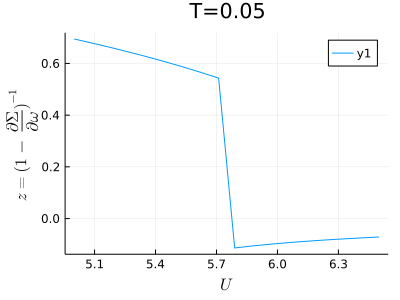

In [13]:
p = plot(xlabel="\$U\$", ylabel = "\$z=(1-\\frac{\\partial \\Sigma}{\\partial \\omega})^{-1}\$", 
        title="T=0.05", size=(400,300))
plot!(U_range, Z)
